Jupyter notebook for fitting a Gaussian distribution to a photopeak in order to determine its properties: amplitude, integral, centroid, standard deviation, and full width at half maximum (FWHM). The fitting programme will also fit a simple degree 2 polynomial background. Provision of an energy calibration allows the fitted centroid, standard deviation and FWHM to be expressed in keV, rather than in channels, and allows the peak resolution to be calculated.

The notebook reads in .Spe data files generated by Maestro software programme. It reads a foreground data file, a background data file and subtracts the background data from the foreground data. It plots the background-subtracted data in order to determine the limits of the fit to be chosen. It then fits the background and plots the result.

Step 1: Import various program modules

Step 2: Input input and output filenames (Before running, upload your foreground and background data files to your Jupyter working directory)

Step 3: Read data from the foreground and background data files

Step 4: Define, initialise and fill the working variables

Step 5: Plot the background-subtracted spectra in channel space

Step 6: Input initial parameters for the fit 

Step 7: Carry out fit and plot initial and final Gaussians

Step 8: Calculate and print out parameters of fitted peak in channel space

Step 9: Input an energy calibration and actual gamma ray energy (if known). Calculates fitted peak parameters  in energy space and peak resolution

Step 10: Replot fitted Gaussian in energy space


In [1]:
# import modules

import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

In [2]:
# choose the names of the input and output data filenames

inputfile1   = "second_measurement_unknown1_600s.Spe"           # Data filename for foreground data
inputfile2   = "second_measurement_background_600s.Spe"     # Data filename for background data
nochannels   = 512                  # Number of channels in the spectrum (usually 512 or 8192)
outputfile1  = 'MaestroFitSpe.pdf' # Data filename for output graph in channel space
outputfile2  = 'MaestroFitSpe2.pdf' # Data filename for output graph in energy space

In [3]:
# read foreground and background data files

with open(inputfile1,'r') as filehandle:  
    filecontent1 = filehandle.readlines()
with open(inputfile2,'r') as filehandle:  
    filecontent2 = filehandle.readlines()          

In [4]:
# define arrays for channels, energy, foreground, background and background subtracted counts

channel = np.array([ x + 1 for x in range(nochannels) ],'i')
energy  = np.array([ x + 1 for x in range(nochannels) ],'f')
yield1  = np.array([ x + 1 for x in range(nochannels) ],'i')
error1  = np.array([ x + 1 for x in range(nochannels) ],'f')
yield2  = np.array([ x + 1 for x in range(nochannels) ],'i')
error2  = np.array([ x + 1 for x in range(nochannels) ],'f')
yield3  = np.array([ x + 1 for x in range(nochannels) ],'i')
error3  = np.array([ x + 1 for x in range(nochannels) ],'f')

# fill the arrays listyield1, listyield2 and listfield3 with data from foreground and background 
# data files and the background subtracted data. The subtraction assumes that the foreground and 
# background data were taken for the same period of time.

count = 0
while count < nochannels:
    count2 = count + 12                                        # Data in .Spe files start from line 12
    yield1[count] = int(filecontent1[count2])                  # foreground data
    yield2[count] = int(filecontent2[count2])                  # background data
    yield3[count] = int(yield1[count]-yield2[count])           # background-subtracted data
    error1[count] = math.sqrt(yield1[count])                   # Poisson errors in foreground data
    error2[count] = math.sqrt(yield2[count])                   # Poisson errors in background data
    error3[count] = math.sqrt(yield1[count]+yield2[count])     # errors in background-subtracted data
    count += 1     

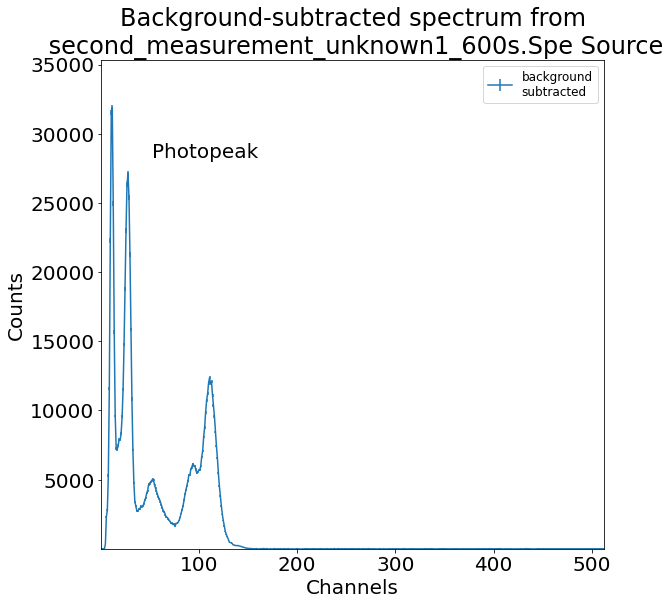

In [12]:
# Plot the background-subtracted spectrum in channel space

figuretitle   = 'Background-subtracted spectrum from\n '+ inputfile1 + ' Source' # set title for the graph
xlabeltext    = "Channels"                                                       # set x-axis label
ylabeltext    = "Counts"                                                         # set y-axis label
annotatetext1 = "Photopeak"                                                      # set text for annotation 1
yaxistype     = "linear"                                                         # choose 'log' or 'linear' for yscale

# select plotting symbols

symbol1='g.'       # choose colour and symbol for foreground data points ('r.', 'go', 'bD', etc.)
symbol2='r.'       # choose colour and symbol for background data points 
symbol3='b.'       # choose colour and symbol for subtracted data points 

# find minimum and maximum x- and y-values in the data to be plotted

xcountsmin=min(channel)
xcountsmax=max(channel)
ycountsmin=min(yield1)
ycountsmax=max(yield1)

# set minimum and maximum scales for x- and y-axes

xplotmin=xcountsmin
xplotmax=xcountsmax
yplotmin=0.1                  # set non-zero value to avoid error if logarithmic y-axis chosen
yplotmax=ycountsmax*1.1

# set location for annotation

annotatexposition1 = xplotmin+0.1*(xplotmax-xplotmin) # use fraction between 0 and 1 to ensure position is within plot area
annotateyposition1 = yplotmin+0.8*(yplotmax-yplotmin) # use fraction between 0 and 1 to ensure position is within plot area

# plot and save the graph

plt.yscale(yaxistype)                                                   # plot 'log' or 'linear' for yscale
plt.rcParams['font.family'] = 'DejaVu Sans'                             # set font style for labels 
plt.rcParams['font.size'] = 20                                          # set font size for labels
plt.rcParams["figure.figsize"] = (4,4)                                  # set figure size (x,y) in inches
plt.axis([xplotmin, xplotmax, yplotmin, yplotmax])                      # plot the graph axes
plt.xlabel(xlabeltext)                                                  # add label for x-axis
plt.ylabel(ylabeltext)                                                  # add label for y-axis
plt.title(figuretitle)                                                  # add figure title
# plt.errorbar(channel,yield1,yerr=error1)                              # plot foreground data
# plt.errorbar(channel,yield2,yerr=error2)                              # plot background data
plt.errorbar(channel,yield3,yerr=error3,label="background\nsubtracted") # plot background-subtracted data
plt.legend(loc=1,prop={'size': 12})                                     # add legend to plot, locate upper right
plt.annotate(annotatetext1,xy=(annotatexposition1,annotateyposition1))  # Sample annotation of graph
plt.savefig(outputfile1,bbox_inches = 'tight')                          # write out spectra to outputfile
plt.show()


In [6]:
# inital guess at parameters of fit

# range of fit (channels)

xfitlower = 10                     # lower x-limit of fit (in channels)
xfitupper = 30                     # upper x-limit of fit (in channels)

# parameters of peak

amplitude = 32000                   # initial guess at amplitude
centroid  = 20                     # initial guess at centroid (in channels)
FWHM      = 5.0                    # initial guess at full width half maximum (FWHM) (in channels) 

# background terms (recommend starting from zero)

constant  = 0.0                     # initial value of constant background term
linear    = 0.0                     # initial value of linear background term
quadratic = 0.0                     # initial value of quadratic background term

In [7]:
sigma=FWHM/2.355                    # calculate sigma from FWHM
params  = [amplitude,centroid,sigma,constant,linear,quadratic] # array for initial fit parameters

# set up arrays for the data to be fitted

nofitpoints = xfitupper - xfitlower + 1

xfitdata    = np.array([x for x in range(nofitpoints)],'i')
xfitdatae   = np.array([x for x in range(nofitpoints)],'f')
yfitdata    = np.array([x for x in range(nofitpoints)],'i')
yerrfitdata = np.array([x for x in range(nofitpoints)],'f')

# fill the arrays with the data to be fitted

count=0
while count<nofitpoints:
    count2=count+xfitlower
    xfitdata[count]=channel[count2]
    yfitdata[count]=yield3[count2]
    yerrfitdata[count]=error3[count2]
    count += 1
    
# define the Gaussian plus background function to be fitted
     # x is the data ordinate
     # the remaining arguments are the function parameters:
          # a is the amplitude
          # x0 is the centroid
          # sigma is the standard deviation
          # const is constant background
          # lin is linear background term
          #quad is quadratic background term  

def gaus(x,a,x0,sigma,const,lin,quad):
    return a*exp(-(x-x0)**2/(2*sigma**2))+const+lin*x+quad*x*x

# define a quadratic background function
     # x is the data ordinate
     # the remaining arguments are the function parameters:
          # const is constant background
          # lin is linear background term
          #quad is quadratic background term  

def background(x,const,lin,quad):
    return const+lin*x+quad*x*x

# fit the function to the data
     # gaus is the function to be fitted
     # x is the data crdinate
     # y is the data co-ordinate
     # params is a list of the inital guesses at the parameter values
     # sigma is error in the co-ordinate data
        
popt,pcov = curve_fit(gaus,xfitdata,yfitdata,p0=params,sigma=yerrfitdata)

# plot the fit

xplotmin = min(xfitdata)
xplotmax = max(xfitdata)

plt.axis([xplotmin, xplotmax, yplotmin, yplotmax])                       # plot the graph axes
plt.xlabel(xlabeltext)                                                   # add label for x-axis
plt.ylabel(ylabeltext)                                                   # add label for y-axis
plt.title(figuretitle)                                                   # add figure title
plt.errorbar(xfitdata,yfitdata,yerr=yerrfitdata,label='data')            # plot original data
plt.plot(xfitdata,gaus(xfitdata,*popt),'ro:',label='fit')                # plot fitted function
plt.plot(xfitdata,gaus(xfitdata,*params),'co:',label='initial guess')    # plot initial function
plt.legend(loc=1,prop={'size': 12})                                      # add legend to plot, locate upper right
plt.show()                                                               # plot the graph

<ipython-input-7-a20d16e1eb15>:34: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return a*exp(-(x-x0)**2/(2*sigma**2))+const+lin*x+quad*x*x


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

In [8]:
# calculate output values
# amplitude, integral, centroid, standard deviation, and full width at half maximum (FWHM).

amplitude = popt[0]
centroid  = popt[1]
sigma     = popt[2]
constant  = popt[3]
linear    = popt[4]
quadratic = popt[5]
integral  = 2.5066*amplitude*sigma
FWHM      = 2.355*sigma

perr = np.sqrt(np.diag(pcov))

amplitudeerror = perr[0]
centroiderror  = perr[1]
sigmaerror     = perr[2]
FWHMerror      = 2.355*sigmaerror
integralerror  = math.sqrt((amplitudeerror**2)/(amplitude**2)+(sigmaerror**2)/(sigma**2))*integral

params2 = [constant,linear,quadratic]      # array for plotting fitted background parameters

# print out peak parameters in channel space

print('Peak amplitude          is ', np.around(amplitude,decimals=2),u"\u00B1",np.around(amplitudeerror,decimals=2),'    counts')
print('Peak integral (net)     is ', np.around(integral,decimals=2),u"\u00B1",np.around(integralerror,decimals=2),' counts')
print('Peak centroid           is ', np.around(centroid,decimals=2),u"\u00B1",np.around(centroiderror,decimals=2),'      channels')
print('Peak standard deviation is ', np.around(sigma,decimals=2),u"\u00B1",np.around(sigmaerror,decimals=2),'        channels')
print('Peak FWHM               is ', np.around(FWHM,decimals=2),u"\u00B1",np.around(FWHMerror,decimals=2),'      channels')

NameError: name 'popt' is not defined

In [9]:
# input energy calibration and actual peak energy, if known.

calibrationgradient = 3.48   # units of keV/channel 
calibrationoffset   = 2      # units of keV
peakenergy          = 662    # known peak energy in keV

# convert fitted parameters from channels to energy and calculate resolution

centroide = centroid*calibrationgradient + calibrationoffset   # centroid in keV
centroideerror= centroiderror*calibrationgradient
FWHMe = FWHM*calibrationgradient                               # FWHM in keV 
FWHMeerror= FWHMerror*calibrationgradient
resolution1 = 100*FWHMe/centroide   # resolution calucated from gaussian fitted width and centroid
resolution1error = math.sqrt((centroideerror**2)/(centroide**2)+(FWHMeerror**2)/(FWHMe**2))*resolution1
resolution2 = 100*FWHMe/peakenergy  # resolution caluclated from gaussian fitted width and known peak energy
resolution2error = (FWHMeerror/FWHMe)*resolution2

# print out peak parameters in energy space

print('Peak centroid   is ', np.around(centroide,decimals=2),u"\u00B1",np.around(centroideerror,decimals=2),' keV')
print('Peak FWHM       is ', np.around(FWHMe,decimals=2),u"\u00B1",np.around(FWHMeerror,decimals=2),'  keV')
print('Peak resolution is ', np.around(resolution1,decimals=2),u"\u00B1",np.around(resolution1error,decimals=2),'% (from measured width and centroid)' )
print('Peak resolution is ', np.around(resolution2,decimals=2),u"\u00B1",np.around(resolution2error,decimals=2),'% (from measured width and known peak energy)')

NameError: name 'centroiderror' is not defined

In [11]:
# replot fitted Gaussian in energy space

# convert the x-data points to energy

count=0
while count<nofitpoints:
    count2=count+xfitlower
    xfitdatae[count]=calibrationgradient*channel[count2]+calibrationoffset
    count += 1

# Caculate parameters for the graph    
    
xplotmin = min(xfitdatae)
xplotmax = max(xfitdatae)  
halfwidthxlow = centroide - 0.5*FWHMe
halfwidthxhigh = centroide + 0.5*FWHMe
halfheight = amplitude/2+constant+centroid*linear+centroid*centroid*quadratic
fullheight = amplitude+constant+centroid*linear+centroid*centroid*quadratic
FWHMeround = round(FWHMe,2)
FWHMtext   = 'FWHM '+str(FWHMeround)+ ' keV'
centroideround = round(centroide,2)
centroidtext= 'Centroid ' + str(centroideround)+ ' keV'
centroidtextheight=halfheight*1.2
xlabeltext = "Energy (keV)"
ylabeltext = "Counts"

# Plot and save a graph of the fitted Gaussian 

plt.axis([xplotmin,xplotmax,yplotmin,yplotmax])                          # set plot area
plt.xlabel(xlabeltext)                                                   # add label for x-axis
plt.ylabel(ylabeltext)                                                   # add label for y-axis
plt.title(figuretitle)                                                   # add figure title
plt.errorbar(xfitdatae,yfitdata,yerr=yerrfitdata,label='data')           # plot original data
plt.plot(xfitdatae,gaus(xfitdata,*popt),'ro:',label='Fitted Gausian')    # plot fitted function
plt.plot(xfitdatae,background(xfitdata,*params2),'co:',label='Fitted background') # plot background function
plt.legend(loc=1,prop={'size': 12})                                      # add legend to plot, locate upper right
plt.plot([centroide,centroide],[yplotmin,fullheight],'-c')               # draw centroid position           
plt.plot([halfwidthxlow,halfwidthxhigh],[halfheight,halfheight],'-c')    # draw FWHM
plt.annotate(FWHMtext,xy=(halfwidthxhigh,halfheight))                    # annotate graph with FWHM
plt.annotate(centroidtext,xy=(halfwidthxhigh,centroidtextheight))        # annotate graph with fitted centroid
plt.savefig(outputfile2,bbox_inches = 'tight')                           # write out fitted Gaussian to outputfile
plt.show()                                                               # plot the graph

NameError: name 'FWHMe' is not defined